## This notebook is to check that we are representing a discrete measure as a tree works

In [1]:
import sys
import os

# Get the absolute path of src/ directory
notebooks_path = os.path.abspath(os.getcwd())  # Get the notebook’s current directory
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))

# Ensure src is in sys.path
if src_path not in sys.path:
    sys.path.insert(0, src_path)  # Insert at the beginning to prioritize it

In [9]:
import numpy as np
import warnings
import time

# Import necessary modules from src
from Measure_sampling.Gen_Path_and_AdaptedTrees import *
from trees.Tree_Node import *
from trees.TreeAnalysis import *
from trees.TreeVisualization import *
from trees.Save_Load_trees import *
from trees.Tree_AWD_utilities import *

from benchmark_value_gaussian.Comp_AWD2_Gaussian import (
    build_mean_and_cov, adapted_wasserstein_squared
)
from awd_trees.Gurobi_AOT import *
from awd_trees.Nested_Dist_Algo import compute_nested_distance

from Conditional_density.CD_nonparam import *

from AOT_numerics.mainfunctions import *
from AOT_numerics.measure import *
from AOT_numerics.normal_ot import *
from AOT_numerics.FVI_bench import *

from Measure_sampling.Extract_Sample_path_AOT import extract_sample_paths

from adapted_empirical_measure.AEM_kMeans import (
    empirical_k_means_measure,
    empirical_k_means_measure_new,
    empirical_k_means_measure_grid,
)
from adapted_empirical_measure.AEM_grid import empirical_grid_measure

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Checking tree vs Gurobi solver for adapted empirical measure

Method: grid
Time Steps: 6, Method: grid, Run 1/10 for sample size 10...
Set parameter Username
Set parameter LicenseID to value 2604970
Academic license - for non-commercial use only - expires 2026-01-03
Sample Size 10, Run 1: Tree Distance = 141.8367, gurobi Distance = 141.8367, Difference = -0.0000
Sample Size 10, Run 1: Tree Time = 0.0181s, gurobi Time = 0.0821s, Time Diff = -0.0640s
Time Steps: 6, Method: grid, Run 2/10 for sample size 10...
Sample Size 10, Run 2: Tree Distance = 214.3380, gurobi Distance = 214.3380, Difference = -0.0000
Sample Size 10, Run 2: Tree Time = 0.0223s, gurobi Time = 0.0587s, Time Diff = -0.0364s
Time Steps: 6, Method: grid, Run 3/10 for sample size 10...
Sample Size 10, Run 3: Tree Distance = 274.1280, gurobi Distance = 274.1280, Difference = 0.0000
Sample Size 10, Run 3: Tree Time = 0.0166s, gurobi Time = 0.0596s, Time Diff = -0.0429s
Time Steps: 6, Method: grid, Run 4/10 for sample size 10...
Sample Size 10, Run 4: Tree Distance = 97.7663, gurobi Dis

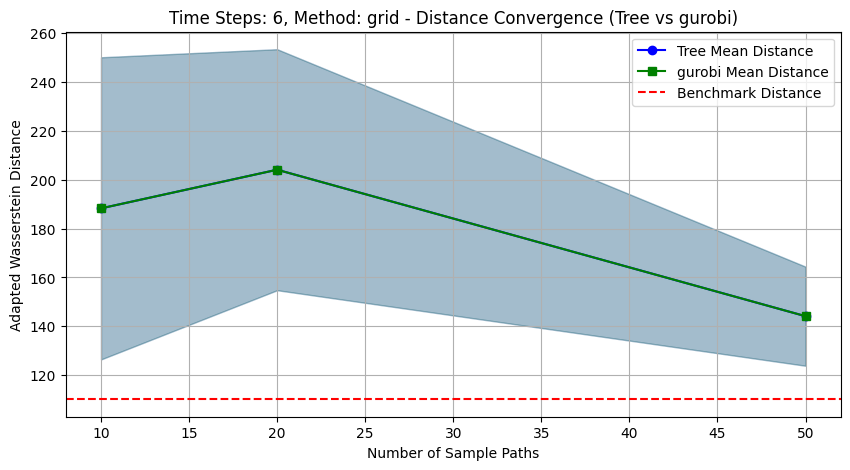

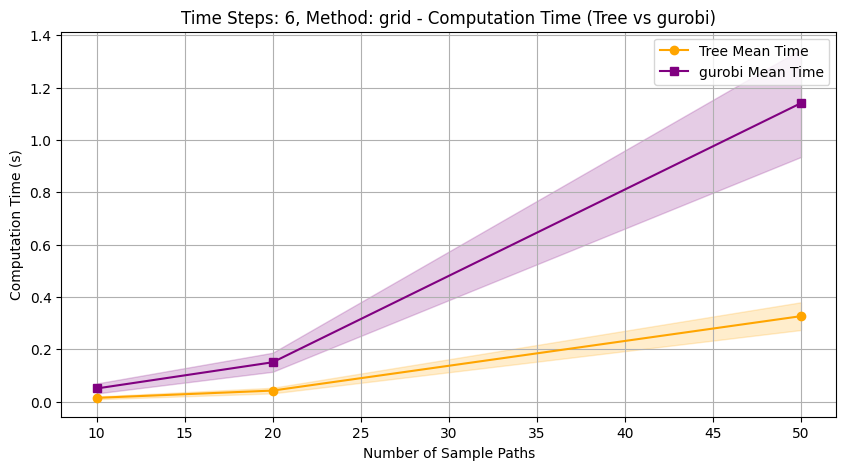

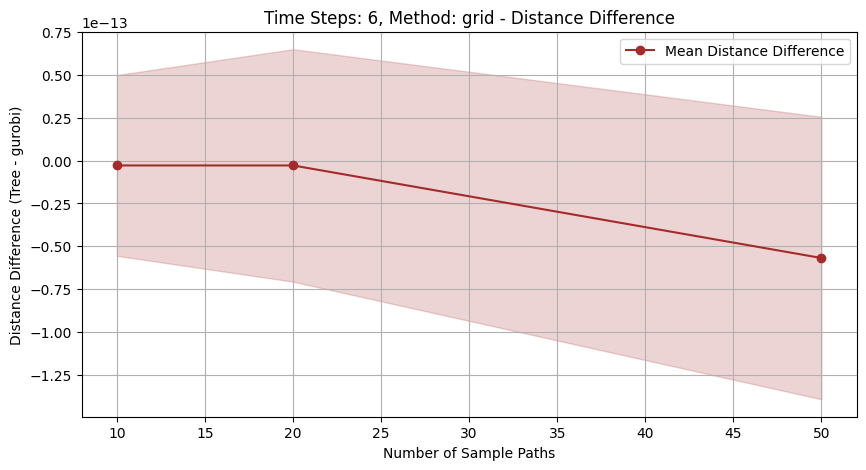

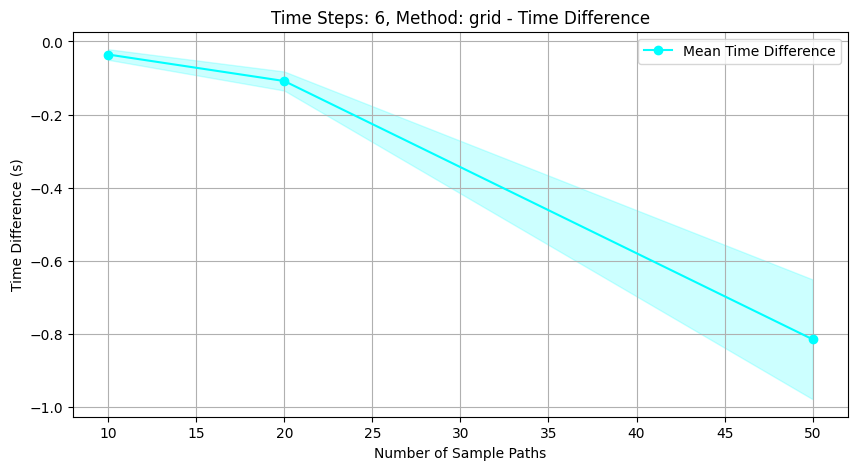

Method: grid
Time Steps: 6, Method: grid, Run 1/10 for sample size 10...
Sample Size 10, Run 1: Tree Distance = 171.4538, gurobi Distance = 171.4538, Difference = 0.0000
Sample Size 10, Run 1: Tree Time = 0.0120s, gurobi Time = 0.0411s, Time Diff = -0.0291s
Time Steps: 6, Method: grid, Run 2/10 for sample size 10...
Sample Size 10, Run 2: Tree Distance = 337.1436, gurobi Distance = 337.1436, Difference = 0.0000
Sample Size 10, Run 2: Tree Time = 0.0119s, gurobi Time = 0.0419s, Time Diff = -0.0300s
Time Steps: 6, Method: grid, Run 3/10 for sample size 10...
Sample Size 10, Run 3: Tree Distance = 612.0972, gurobi Distance = 612.0972, Difference = -0.0000
Sample Size 10, Run 3: Tree Time = 0.0167s, gurobi Time = 0.0643s, Time Diff = -0.0476s
Time Steps: 6, Method: grid, Run 4/10 for sample size 10...
Sample Size 10, Run 4: Tree Distance = 286.4905, gurobi Distance = 286.4905, Difference = -0.0000
Sample Size 10, Run 4: Tree Time = 0.0248s, gurobi Time = 0.0811s, Time Diff = -0.0564s
Time 

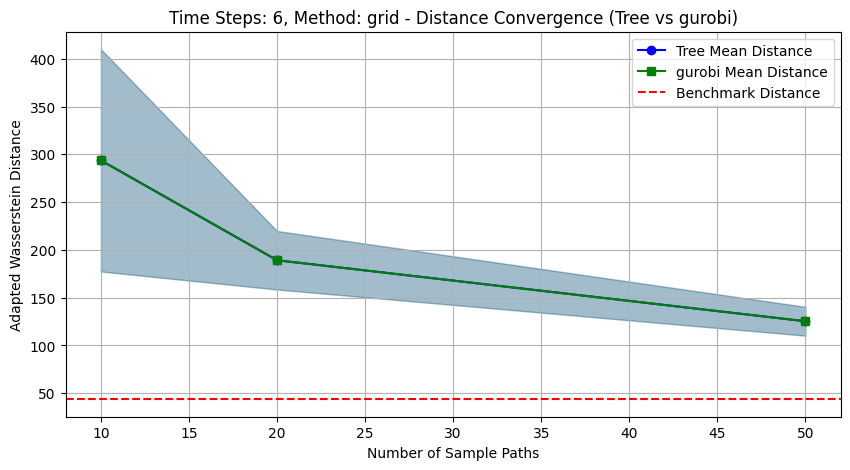

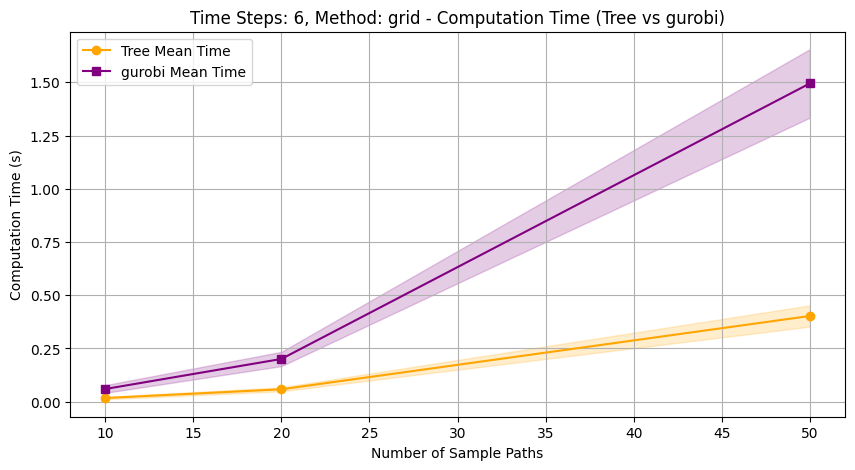

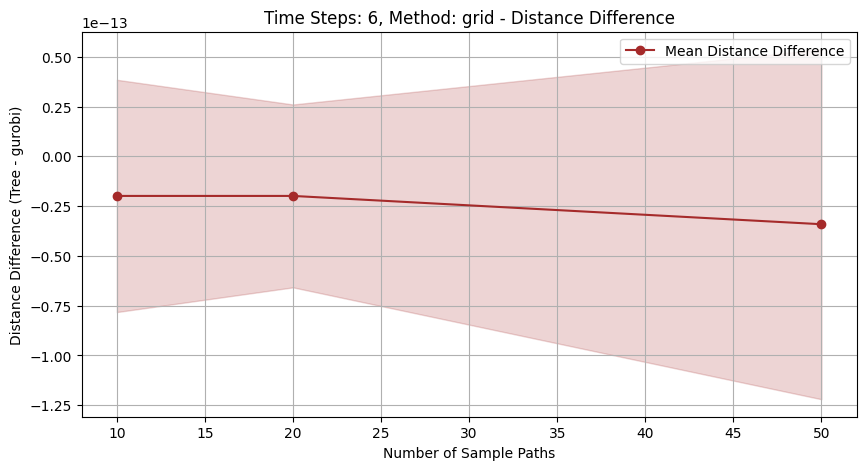

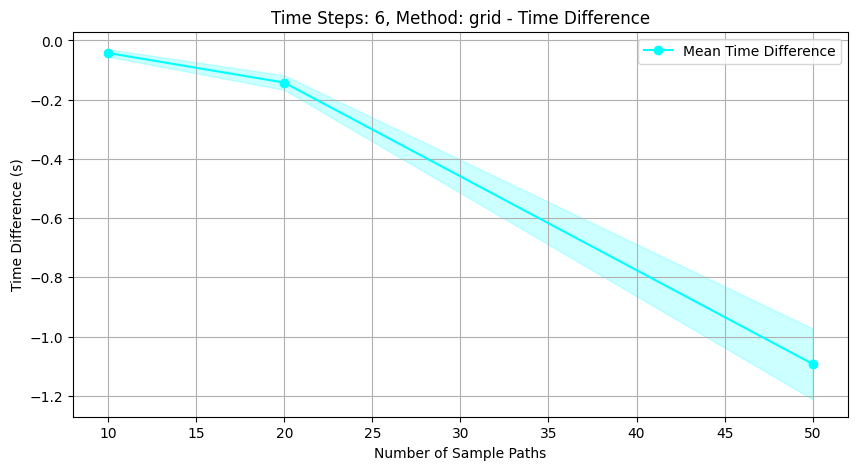

Method: grid
Time Steps: 6, Method: grid, Run 1/10 for sample size 10...
Sample Size 10, Run 1: Tree Distance = 135.4235, gurobi Distance = 135.4235, Difference = 0.0000
Sample Size 10, Run 1: Tree Time = 0.0126s, gurobi Time = 0.0497s, Time Diff = -0.0371s
Time Steps: 6, Method: grid, Run 2/10 for sample size 10...
Sample Size 10, Run 2: Tree Distance = 214.9897, gurobi Distance = 214.9897, Difference = 0.0000
Sample Size 10, Run 2: Tree Time = 0.0130s, gurobi Time = 0.0470s, Time Diff = -0.0340s
Time Steps: 6, Method: grid, Run 3/10 for sample size 10...
Sample Size 10, Run 3: Tree Distance = 230.5563, gurobi Distance = 230.5563, Difference = 0.0000
Sample Size 10, Run 3: Tree Time = 0.0183s, gurobi Time = 0.1419s, Time Diff = -0.1236s
Time Steps: 6, Method: grid, Run 4/10 for sample size 10...
Sample Size 10, Run 4: Tree Distance = 227.6404, gurobi Distance = 227.6404, Difference = -0.0000
Sample Size 10, Run 4: Tree Time = 0.0240s, gurobi Time = 0.0353s, Time Diff = -0.0113s
Time S

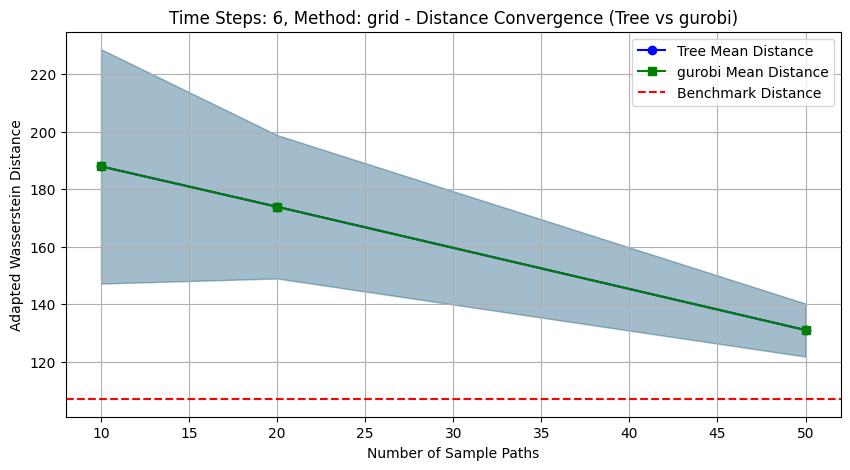

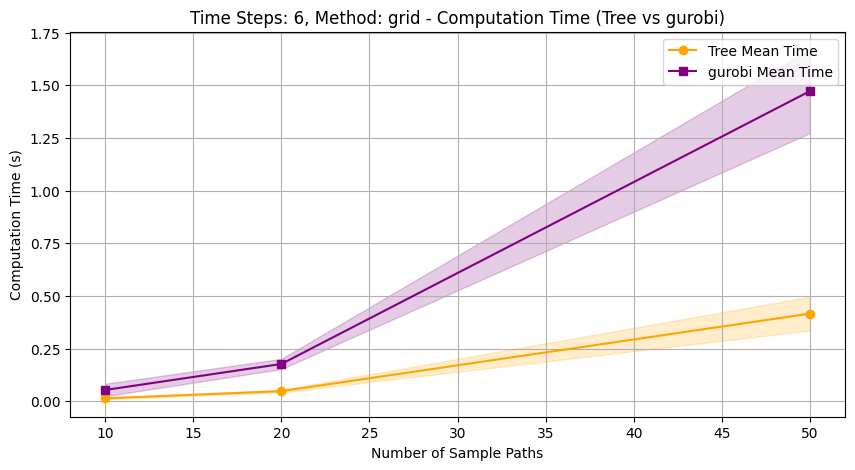

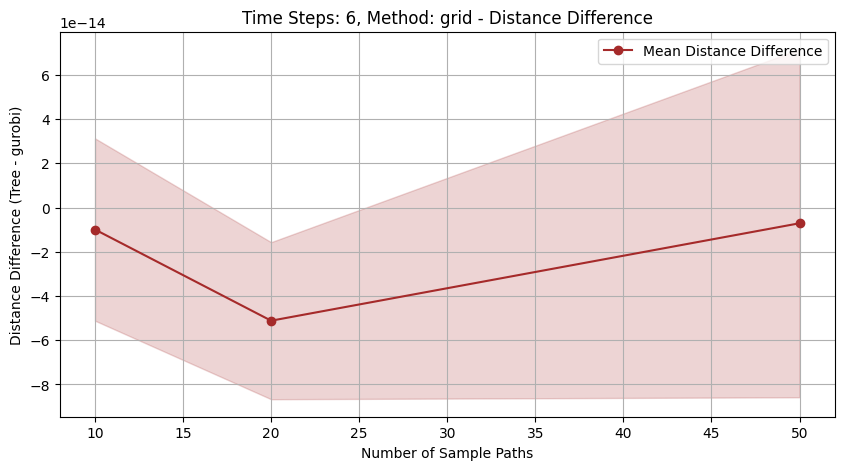

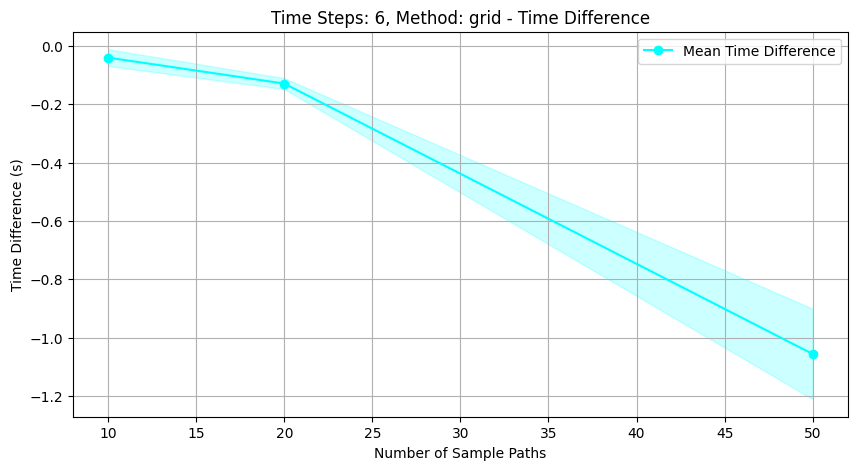

In [10]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt


def nearest_pd(A):
    """Find the nearest positive-definite matrix to A."""
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = V.T @ np.diag(s) @ V
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    # Ensure positive definiteness by adding a small identity matrix if needed.
    if is_pd(A3):
        return A3
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 0.5
    while not is_pd(A3):
        A3 += I * spacing * k
        k += 1
    return A3


def is_pd(B):
    """Return True if B is positive-definite."""
    try:
        np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False


Sigma1 = np.array(
    [
        [35, 30, -3, 2, -20],
        [30, 35, 3, -6, 40],
        [-3, 33, 10, 3, -2],
        [2, -1.5, 3, 0.5, 0.25],
        [-20, 40, -2, 0.25, 30],
    ]
)
Sigma1 = (Sigma1 + Sigma1.T) / 2  # ensure symmetry

# Covariance Matrix Sigma2:
# - Variances: [25, 5, 16, 3.2, 9] corresponding to std devs: 5, ~2.24, 4, ~1.79, 3.
# - Sparse, extreme off-diagonals: a strong negative tie between X1 and X3 and smaller interactions elsewhere.
Sigma2 = np.array(
    [
        [25, 0, -20, 0, 1.5],
        [0, 5, 0, -0.4, 0],
        [-20, 0, 16, 0, -1.2],
        [0, -0.4, 0, 3.2, 0],
        [1.5, 0, -1.2, 0, 9],
    ]
)
Sigma2 = (Sigma2 + Sigma2.T) / 2  # ensure symmetry


Sigma3 = np.array(
    [
        [30, 15, 5, 10, -20],
        [15, 25, 12, -8, 5],
        [5, 12, 20, 7, -3],
        [10, -8, 7, 10, 4],
        [-20, 5, -3, 4, 30],
    ]
)
Sigma3 = (Sigma3 + Sigma3.T) / 2  # ensure symmetry


# Adjust the covariance matrices to be positive-definite.
sigma1_pd = nearest_pd(Sigma1)
sigma2_pd = nearest_pd(Sigma2)
sigma3_pd = nearest_pd(Sigma3)


# Mean vector (zero for both)
mean = np.zeros(5)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the methods and time steps to loop over
method = "grid"
time_steps_list = [6]
n_runs = 10

# Define sample path sizes for each time step
sample_sizes = [10, 20, 50]

# Prepare arrays for storing tree and gurobi results
distances_all_tree = np.zeros((len(sample_sizes), n_runs))
times_all_tree = np.zeros((len(sample_sizes), n_runs))
distances_all_gurobi = np.zeros((len(sample_sizes), n_runs))
times_all_gurobi = np.zeros((len(sample_sizes), n_runs))
diff_distance_all = np.zeros((len(sample_sizes), n_runs))
diff_time_all = np.zeros((len(sample_sizes), n_runs))

# Loop over each time step and method combination
for time_steps in time_steps_list:
    for value in [1, 2, 3]:
        Sigma_A = 0
        Sigma_B = 0
        if value == 1:
            Sigma_A = sigma1_pd
            Sigma_B = sigma2_pd
        elif value == 2:
            Sigma_A = sigma1_pd
            Sigma_B = sigma3_pd
        elif value == 3:
            Sigma_A = sigma2_pd
            Sigma_B = sigma3_pd

        print("Method:", method)
        # distance_squared is used as a benchmark
        distance_squared = adapted_wasserstein_squared(mean, Sigma_A, mean, Sigma_B)

        # Loop over each sample size and run n_runs for statistics
        for i, num_paths in enumerate(sample_sizes):
            for run_idx in range(n_runs):
                print(
                    f"Time Steps: {time_steps}, Method: {method}, Run {run_idx+1}/{n_runs} for sample size {num_paths}..."
                )

                # Generate samples for both measures
                samplesA = np.random.multivariate_normal(mean, Sigma_A, size=num_paths)
                samplesB = np.random.multivariate_normal(mean, Sigma_B, size=num_paths)
                samplesA_with_zero = np.hstack([np.zeros((num_paths, 1)), samplesA])
                samplesB_with_zero = np.hstack([np.zeros((num_paths, 1)), samplesB])

                # Compute the empirical grid measures (paths and weights)
                new_sample_pathsA, new_weightsA = empirical_grid_measure(
                    samplesA_with_zero, use_weights=True
                )
                new_sample_pathsB, new_weightsB = empirical_grid_measure(
                    samplesB_with_zero, use_weights=True
                )

                # ---------------------------
                # Build representations:
                # ---------------------------
                # (A) Tree-based construction:
                tree1 = build_tree_from_paths(new_sample_pathsA, new_weightsA)
                tree2 = build_tree_from_paths(new_sample_pathsB, new_weightsB)

                formatedA = [new_sample_pathsA, new_weightsA]
                formatedB = [new_sample_pathsB, new_weightsB]

                # ---------------------------
                # Compute nested distance using the tree:
                # ---------------------------
                max_depth_tree = get_depth(tree2)
                start_time_tree = time.time()
                distance_tree = compute_nested_distance(
                    tree1,
                    tree2,
                    max_depth_tree,
                    method="solver_lp_pot",
                    return_matrix=False,
                    lambda_reg=0,
                    power=2,
                )
                elapsed_time_tree = time.time() - start_time_tree

                # ---------------------------
                # Compute nested distance using gurobi_bm:
                # ---------------------------

                def cost_function(x, y):
                    """Cost function: L1 distance."""
                    return np.sum(np.abs(x - y) ** 2)

                start_time_gurobi = time.time()
                distance_gurobi = gurobi_bm(
                    [formatedA, formatedB],
                    f=cost_function,
                    r_opti=0,
                    causal=1,
                    anticausal=1,
                    outputflag=0,
                )

                elapsed_time_gurobi = time.time() - start_time_gurobi

                # (Optional) Adjust distance by subtracting any constant if needed:
                distance_tree -= (0 - 0) ** 2
                distance_gurobi -= (0 - 0) ** 2

                # Store the computed distances and computation times:
                distances_all_tree[i, run_idx] = distance_tree
                times_all_tree[i, run_idx] = elapsed_time_tree
                distances_all_gurobi[i, run_idx] = distance_gurobi
                times_all_gurobi[i, run_idx] = elapsed_time_gurobi

                # Also store the differences (tree - gurobi)
                diff_distance_all[i, run_idx] = distance_tree - distance_gurobi
                diff_time_all[i, run_idx] = elapsed_time_tree - elapsed_time_gurobi

                print(
                    f"Sample Size {num_paths}, Run {run_idx+1}: Tree Distance = {distance_tree:.4f}, gurobi Distance = {distance_gurobi:.4f}, Difference = {distance_tree - distance_gurobi:.4f}"
                )
                print(
                    f"Sample Size {num_paths}, Run {run_idx+1}: Tree Time = {elapsed_time_tree:.4f}s, gurobi Time = {elapsed_time_gurobi:.4f}s, Time Diff = {elapsed_time_tree - elapsed_time_gurobi:.4f}s"
                )

        # ---------------------------
        # Compute statistics over runs:
        # ---------------------------
        # Tree statistics:
        distances_tree_mean = distances_all_tree.mean(axis=1)
        distances_tree_std = distances_all_tree.std(axis=1)
        times_tree_mean = times_all_tree.mean(axis=1)
        times_tree_std = times_all_tree.std(axis=1)
        # gurobi statistics:
        distances_gurobi_mean = distances_all_gurobi.mean(axis=1)
        distances_gurobi_std = distances_all_gurobi.std(axis=1)
        times_gurobi_mean = times_all_gurobi.mean(axis=1)
        times_gurobi_std = times_all_gurobi.std(axis=1)
        # Difference statistics:
        diff_distance_mean = diff_distance_all.mean(axis=1)
        diff_distance_std = diff_distance_all.std(axis=1)
        diff_time_mean = diff_time_all.mean(axis=1)
        diff_time_std = diff_time_all.std(axis=1)

        # ---------------------------
        # PLOTTING
        # ---------------------------
        # Plot 1: Distance convergence for Tree vs. gurobi
        plt.figure(figsize=(10, 5))
        plt.plot(
            sample_sizes,
            distances_tree_mean,
            marker="o",
            color="blue",
            label="Tree Mean Distance",
        )
        plt.plot(
            sample_sizes,
            distances_gurobi_mean,
            marker="s",
            color="green",
            label="gurobi Mean Distance",
        )
        plt.fill_between(
            sample_sizes,
            distances_tree_mean - distances_tree_std,
            distances_tree_mean + distances_tree_std,
            color="blue",
            alpha=0.2,
        )
        plt.fill_between(
            sample_sizes,
            distances_gurobi_mean - distances_gurobi_std,
            distances_gurobi_mean + distances_gurobi_std,
            color="green",
            alpha=0.2,
        )
        plt.axhline(
            y=distance_squared, color="red", linestyle="--", label="Benchmark Distance"
        )
        plt.xlabel("Number of Sample Paths")
        plt.ylabel("Adapted Wasserstein Distance")
        plt.title(
            f"Time Steps: {time_steps}, Method: {method} - Distance Convergence (Tree vs gurobi)"
        )
        plt.legend()
        plt.grid()
        plt.show()

        # Plot 2: Computation Time for Tree vs. gurobi
        plt.figure(figsize=(10, 5))
        plt.plot(
            sample_sizes,
            times_tree_mean,
            marker="o",
            color="orange",
            label="Tree Mean Time",
        )
        plt.plot(
            sample_sizes,
            times_gurobi_mean,
            marker="s",
            color="purple",
            label="gurobi Mean Time",
        )
        plt.fill_between(
            sample_sizes,
            times_tree_mean - times_tree_std,
            times_tree_mean + times_tree_std,
            color="orange",
            alpha=0.2,
        )
        plt.fill_between(
            sample_sizes,
            times_gurobi_mean - times_gurobi_std,
            times_gurobi_mean + times_gurobi_std,
            color="purple",
            alpha=0.2,
        )
        plt.xlabel("Number of Sample Paths")
        plt.ylabel("Computation Time (s)")
        plt.title(
            f"Time Steps: {time_steps}, Method: {method} - Computation Time (Tree vs gurobi)"
        )
        plt.legend()
        plt.grid()
        plt.show()

        # Plot 3: Difference in Distance (Tree - gurobi)
        plt.figure(figsize=(10, 5))
        plt.plot(
            sample_sizes,
            diff_distance_mean,
            marker="o",
            color="brown",
            label="Mean Distance Difference",
        )
        plt.fill_between(
            sample_sizes,
            diff_distance_mean - diff_distance_std,
            diff_distance_mean + diff_distance_std,
            color="brown",
            alpha=0.2,
        )
        plt.xlabel("Number of Sample Paths")
        plt.ylabel("Distance Difference (Tree - gurobi)")
        plt.title(f"Time Steps: {time_steps}, Method: {method} - Distance Difference")
        plt.legend()
        plt.grid()
        plt.show()

        # Plot 4: Difference in Computation Time (Tree - gurobi)
        plt.figure(figsize=(10, 5))
        plt.plot(
            sample_sizes,
            diff_time_mean,
            marker="o",
            color="cyan",
            label="Mean Time Difference",
        )
        plt.fill_between(
            sample_sizes,
            diff_time_mean - diff_time_std,
            diff_time_mean + diff_time_std,
            color="cyan",
            alpha=0.2,
        )
        plt.xlabel("Number of Sample Paths")
        plt.ylabel("Time Difference (s)")
        plt.title(f"Time Steps: {time_steps}, Method: {method} - Time Difference")
        plt.legend()
        plt.grid()
        plt.show()

## Doing the same as above but with more explicit non-markovian process

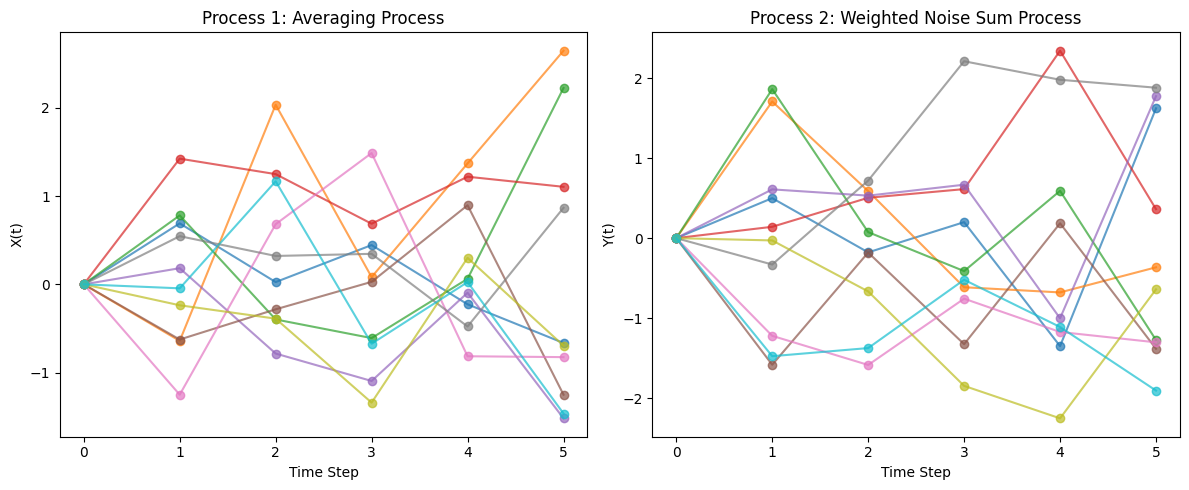

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
num_paths = 200  # number of sample paths
T = 6  # number of time steps (including t=0)
sigma = 1.0  # standard deviation for noise

# Process 1: Averaging process (update depends on the full past average)
# This is non-Markovian since the update at time t uses the mean of all previous values.
X = np.zeros((num_paths, T))
for i in range(num_paths):
    X[i, 0] = 0  # initial value
    for t in range(1, T):
        past_mean = np.mean(X[i, :t])
        X[i, t] = past_mean + np.random.normal(0, sigma)

# Process 2: Weighted noise sum process (each step is a weighted sum of all past noise)
# The weights are chosen as 1/(lag) so that the contribution of past noise is non-negligible.
Y = np.zeros((num_paths, T))
for i in range(num_paths):
    # Generate a sequence of independent noise values for this sample path
    noise = np.random.normal(0, sigma, T)
    Y[i, 0] = 0  # initial value
    for t in range(1, T):
        weighted_sum = 0
        for s in range(t):
            # weight decreases with the lag; note that for s = t-1 the weight is 1.
            weight = 1 / (t - s)
            weighted_sum += weight * noise[s]
        Y[i, t] = weighted_sum

# Optional: Plot a few sample paths from each process
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i in range(10):  # plot 10 sample paths for clarity
    plt.plot(range(T), X[i, :], marker="o", alpha=0.7)
plt.title("Process 1: Averaging Process")
plt.xlabel("Time Step")
plt.ylabel("X(t)")

plt.subplot(1, 2, 2)
for i in range(10):
    plt.plot(range(T), Y[i, :], marker="o", alpha=0.7)
plt.title("Process 2: Weighted Noise Sum Process")
plt.xlabel("Time Step")
plt.ylabel("Y(t)")

plt.tight_layout()
plt.show()

Method: grid
Time Steps: 6, Method: grid, Run 1/10 for sample size 10...
Sample Size 10, Run 1: Tree Distance = 9.6616, gurobi Distance = 9.6616, Difference = 0.0000
Sample Size 10, Run 1: Tree Time = 0.0248s, gurobi Time = 0.0792s, Time Diff = -0.0544s
Time Steps: 6, Method: grid, Run 2/10 for sample size 10...
Sample Size 10, Run 2: Tree Distance = 16.8163, gurobi Distance = 16.8163, Difference = 0.0000
Sample Size 10, Run 2: Tree Time = 0.0220s, gurobi Time = 0.0764s, Time Diff = -0.0545s
Time Steps: 6, Method: grid, Run 3/10 for sample size 10...
Sample Size 10, Run 3: Tree Distance = 12.4162, gurobi Distance = 12.4162, Difference = -0.0000
Sample Size 10, Run 3: Tree Time = 0.0143s, gurobi Time = 0.0509s, Time Diff = -0.0366s
Time Steps: 6, Method: grid, Run 4/10 for sample size 10...
Sample Size 10, Run 4: Tree Distance = 16.6544, gurobi Distance = 16.6544, Difference = -0.0000
Sample Size 10, Run 4: Tree Time = 0.0164s, gurobi Time = 0.0604s, Time Diff = -0.0440s
Time Steps: 6, 

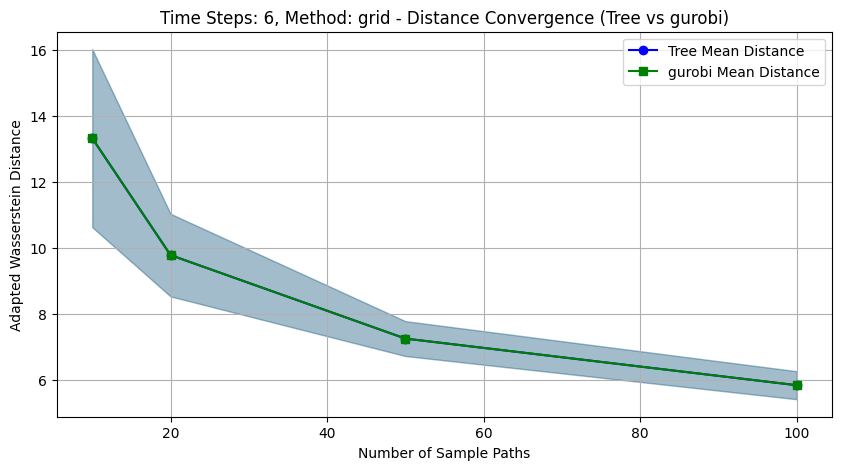

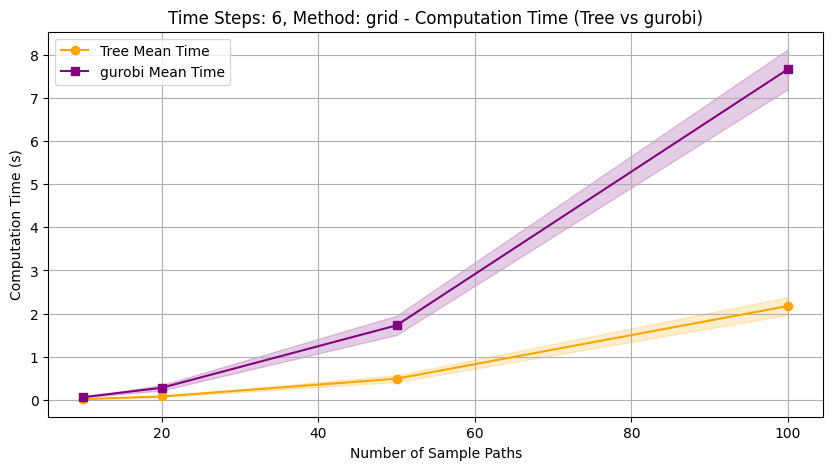

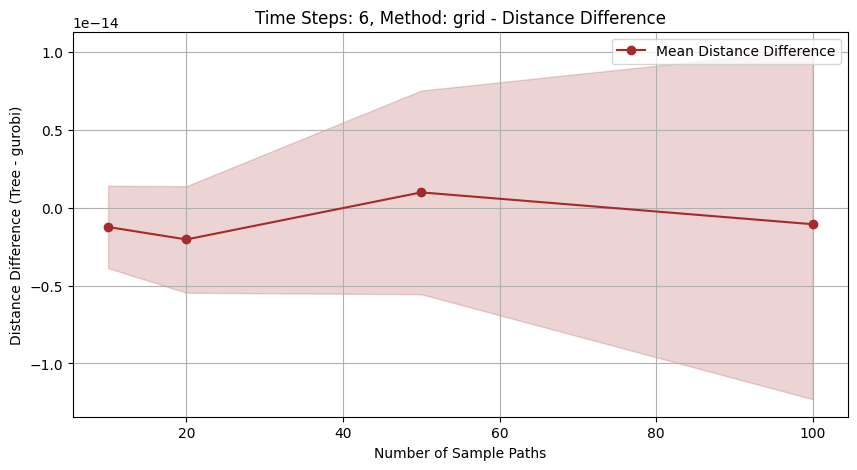

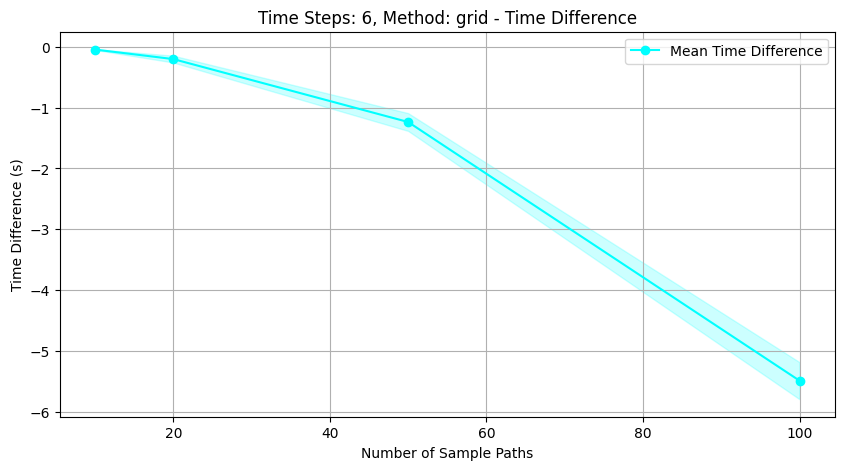

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the method and time steps to loop over
method = "grid"
time_steps_list = [6]  # total number of time steps (including t=0)
n_runs = 10

# Define sample path sizes for each time step
sample_sizes = [10, 20, 50, 100]

# Prepare arrays for storing tree and gurobi results
distances_all_tree = np.zeros((len(sample_sizes), n_runs))
times_all_tree = np.zeros((len(sample_sizes), n_runs))
distances_all_gurobi = np.zeros((len(sample_sizes), n_runs))
times_all_gurobi = np.zeros((len(sample_sizes), n_runs))
diff_distance_all = np.zeros((len(sample_sizes), n_runs))
diff_time_all = np.zeros((len(sample_sizes), n_runs))

distance_benchmark = np.nan

# Noise standard deviation used in the two processes
sigma = 1.0

# Loop over each time step and method combination
for time_steps in time_steps_list:
    print("Method:", method)

    # Loop over each sample size and run multiple trials for statistics
    for i, num_paths in enumerate(sample_sizes):
        for run_idx in range(n_runs):
            print(
                f"Time Steps: {time_steps}, Method: {method}, Run {run_idx+1}/{n_runs} for sample size {num_paths}..."
            )

            T = time_steps  # number of time steps (assumes t=0 is included)

            # ---------------------------
            # Generate non-Markovian sample paths:
            # ---------------------------
            # Process 1: Averaging Process (update uses the full past)
            samplesA = np.zeros((num_paths, T))
            for j in range(num_paths):
                samplesA[j, 0] = 0  # initial condition
                for t in range(1, T):
                    past_mean = np.mean(samplesA[j, :t])
                    samplesA[j, t] = past_mean + np.random.normal(0, sigma)

            # Process 2: Weighted Noise Sum Process (each step is a weighted sum of past noise)
            samplesB = np.zeros((num_paths, T))
            for j in range(num_paths):
                # Generate a noise sequence for this sample path
                noise = np.random.normal(0, sigma, T)
                samplesB[j, 0] = 0  # initial condition
                for t in range(1, T):
                    weighted_sum = 0
                    for s in range(t):
                        weight = 1 / (t - s)
                        weighted_sum += weight * noise[s]
                    samplesB[j, t] = weighted_sum

            # here we assume that the processes already start at zero.)
            samplesA_with_zero = samplesA
            samplesB_with_zero = samplesB

            # ---------------------------
            # Compute the empirical grid measures (paths and weights)
            # ---------------------------
            new_sample_pathsA, new_weightsA = empirical_grid_measure(
                samplesA_with_zero, use_weights=True
            )
            new_sample_pathsB, new_weightsB = empirical_grid_measure(
                samplesB_with_zero, use_weights=True
            )

            # ---------------------------
            # Build tree/gurobi representations:
            # ---------------------------
            tree1 = build_tree_from_paths(new_sample_pathsA, new_weightsA)
            tree2 = build_tree_from_paths(new_sample_pathsB, new_weightsB)

            formatedA = [new_sample_pathsA, new_weightsA]
            formatedB = [new_sample_pathsB, new_weightsB]

            # ---------------------------
            # Compute nested distance using the tree:
            # ---------------------------
            max_depth_tree = get_depth(tree2)
            start_time_tree = time.time()
            distance_tree = compute_nested_distance(
                tree1,
                tree2,
                max_depth_tree,
                method="solver_lp_pot",
                return_matrix=False,
                lambda_reg=0,
                power=2,
            )
            elapsed_time_tree = time.time() - start_time_tree

            # ---------------------------
            # Compute nested distance using the gurobi:
            # ---------------------------
            def cost_function(x, y):
                """Cost function: L1 distance squared."""
                return np.sum(np.abs(x - y) ** 2)

            start_time_gurobi = time.time()
            distance_gurobi = gurobi_bm(
                [formatedA, formatedB],
                f=cost_function,
                r_opti=0,
                causal=1,
                anticausal=1,
                outputflag=0,
            )
            elapsed_time_gurobi = time.time() - start_time_gurobi

            # (Optional) Adjust the computed distances by subtracting any constant (here, 0)
            distance_tree -= (0 - 0) ** 2
            distance_gurobi -= (0 - 0) ** 2

            # Store the computed distances and computation times:
            distances_all_tree[i, run_idx] = distance_tree
            times_all_tree[i, run_idx] = elapsed_time_tree
            distances_all_gurobi[i, run_idx] = distance_gurobi
            times_all_gurobi[i, run_idx] = elapsed_time_gurobi

            # Also store the differences (tree - gurobi)
            diff_distance_all[i, run_idx] = distance_tree - distance_gurobi
            diff_time_all[i, run_idx] = elapsed_time_tree - elapsed_time_gurobi

            print(
                f"Sample Size {num_paths}, Run {run_idx+1}: Tree Distance = {distance_tree:.4f}, gurobi Distance = {distance_gurobi:.4f}, Difference = {distance_tree - distance_gurobi:.4f}"
            )
            print(
                f"Sample Size {num_paths}, Run {run_idx+1}: Tree Time = {elapsed_time_tree:.4f}s, gurobi Time = {elapsed_time_gurobi:.4f}s, Time Diff = {elapsed_time_tree - elapsed_time_gurobi:.4f}s"
            )

    # ---------------------------
    # Compute statistics over runs:
    # ---------------------------
    # Tree statistics:
    distances_tree_mean = distances_all_tree.mean(axis=1)
    distances_tree_std = distances_all_tree.std(axis=1)
    times_tree_mean = times_all_tree.mean(axis=1)
    times_tree_std = times_all_tree.std(axis=1)
    # gurobi statistics:
    distances_gurobi_mean = distances_all_gurobi.mean(axis=1)
    distances_gurobi_std = distances_all_gurobi.std(axis=1)
    times_gurobi_mean = times_all_gurobi.mean(axis=1)
    times_gurobi_std = times_all_gurobi.std(axis=1)
    # Difference statistics:
    diff_distance_mean = diff_distance_all.mean(axis=1)
    diff_distance_std = diff_distance_all.std(axis=1)
    diff_time_mean = diff_time_all.mean(axis=1)
    diff_time_std = diff_time_all.std(axis=1)

    # ---------------------------
    # PLOTTING
    # ---------------------------
    # Plot 1: Distance convergence for Tree vs. gurobi
    plt.figure(figsize=(10, 5))
    plt.plot(
        sample_sizes,
        distances_tree_mean,
        marker="o",
        color="blue",
        label="Tree Mean Distance",
    )
    plt.plot(
        sample_sizes,
        distances_gurobi_mean,
        marker="s",
        color="green",
        label="gurobi Mean Distance",
    )
    plt.fill_between(
        sample_sizes,
        distances_tree_mean - distances_tree_std,
        distances_tree_mean + distances_tree_std,
        color="blue",
        alpha=0.2,
    )
    plt.fill_between(
        sample_sizes,
        distances_gurobi_mean - distances_gurobi_std,
        distances_gurobi_mean + distances_gurobi_std,
        color="green",
        alpha=0.2,
    )
    if not np.isnan(distance_benchmark):
        plt.axhline(
            y=distance_benchmark,
            color="red",
            linestyle="--",
            label="Benchmark Distance",
        )
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Adapted Wasserstein Distance")
    plt.title(
        f"Time Steps: {time_steps}, Method: {method} - Distance Convergence (Tree vs gurobi)"
    )
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 2: Computation Time for Tree vs. gurobi
    plt.figure(figsize=(10, 5))
    plt.plot(
        sample_sizes,
        times_tree_mean,
        marker="o",
        color="orange",
        label="Tree Mean Time",
    )
    plt.plot(
        sample_sizes,
        times_gurobi_mean,
        marker="s",
        color="purple",
        label="gurobi Mean Time",
    )
    plt.fill_between(
        sample_sizes,
        times_tree_mean - times_tree_std,
        times_tree_mean + times_tree_std,
        color="orange",
        alpha=0.2,
    )
    plt.fill_between(
        sample_sizes,
        times_gurobi_mean - times_gurobi_std,
        times_gurobi_mean + times_gurobi_std,
        color="purple",
        alpha=0.2,
    )
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Computation Time (s)")
    plt.title(
        f"Time Steps: {time_steps}, Method: {method} - Computation Time (Tree vs gurobi)"
    )
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 3: Difference in Distance (Tree - gurobi)
    plt.figure(figsize=(10, 5))
    plt.plot(
        sample_sizes,
        diff_distance_mean,
        marker="o",
        color="brown",
        label="Mean Distance Difference",
    )
    plt.fill_between(
        sample_sizes,
        diff_distance_mean - diff_distance_std,
        diff_distance_mean + diff_distance_std,
        color="brown",
        alpha=0.2,
    )
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Distance Difference (Tree - gurobi)")
    plt.title(f"Time Steps: {time_steps}, Method: {method} - Distance Difference")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 4: Difference in Computation Time (Tree - gurobi)
    plt.figure(figsize=(10, 5))
    plt.plot(
        sample_sizes,
        diff_time_mean,
        marker="o",
        color="cyan",
        label="Mean Time Difference",
    )
    plt.fill_between(
        sample_sizes,
        diff_time_mean - diff_time_std,
        diff_time_mean + diff_time_std,
        color="cyan",
        alpha=0.2,
    )
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Time Difference (s)")
    plt.title(f"Time Steps: {time_steps}, Method: {method} - Time Difference")
    plt.legend()
    plt.grid()
    plt.show()

## checking if indeed my build_tree_from_paths follow the backward rule presented in the email

In [6]:
def build_tree_from_paths_backward(sample_paths, weights):
    """
    Builds a weighted tree from sample paths using an explicit backward computation.

    Parameters:
      - sample_paths (list of lists): Each inner list represents a path (e.g. [10, 13, 14, 15]).
      - weights (list of floats): The weight corresponding to each sample path.

    Returns:
      - TreeNode: The root of the constructed tree.

    Raises:
      - ValueError: If sample paths don't all start with the same value,
                    if sample paths have different lengths,
                    or if the sum of weights is not equal to 1.
    """

    # Check that all sample paths start with the same value.
    start_value = sample_paths[0][0]
    for path in sample_paths:
        if path[0] != start_value:
            raise ValueError(
                "All sample paths must have the same value at time step 0."
            )

    # Check that all sample paths have the same length.
    L = len(sample_paths[0])
    for path in sample_paths:
        if len(path) != L:
            raise ValueError("All sample paths must have the same length.")

    # Check that the sum of weights equals 1.
    total_weight = sum(weights)
    if abs(total_weight - 1.0) > 1e-6:
        raise ValueError(
            "The sum of weights must equal 1. Got sum(weights) = {}".format(
                total_weight
            )
        )

    # Create a mapping from prefix (tuple) to (TreeNode, aggregated weight).
    # Start at the leaves: each full sample path defines a leaf node.
    node_info = {}
    for path, w in zip(sample_paths, weights):
        prefix = tuple(path)
        if prefix not in node_info:
            node_info[prefix] = [TreeNode(path[-1]), 0.0]
        node_info[prefix][1] += w

    # Process backwards from the second-to-last index down to 0.
    # At each time step t, group sample paths by their prefix of length t+1.
    for t in range(L - 2, -1, -1):
        new_node_info = {}
        # Process each sample path along with its weight.
        for path, w in zip(sample_paths, weights):
            prefix = tuple(path[: t + 1])
            child_prefix = tuple(path[: t + 2])
            # Retrieve the child node from the previous iteration.
            child_node, _ = node_info[child_prefix]
            # If we haven't created a node for this prefix, do so now.
            if prefix not in new_node_info:
                # Third element is a temporary dictionary to aggregate children info.
                new_node_info[prefix] = [TreeNode(path[t]), 0.0, {}]
            # Update the parent's aggregated weight.
            new_node_info[prefix][1] += w
            # Update children info: accumulate the weight for this particular child.
            children_info = new_node_info[prefix][2]
            if child_node.value not in children_info:
                children_info[child_node.value] = [child_node, 0.0]
            children_info[child_node.value][1] += w

        # Attach children to each new parent node, normalizing the transition probabilities.
        for prefix, (node, total_w, children_info) in new_node_info.items():
            for child_val, (child_node, trans_w) in children_info.items():
                probability = trans_w / total_w if total_w > 0 else 0
                node.add_child(child_node, probability)
            # Replace with just the (node, total_weight) pair.
            new_node_info[prefix] = [node, total_w]

        # Update the node_info mapping for the next iteration.
        node_info = {k: (v[0], v[1]) for k, v in new_node_info.items()}

    # The root node is associated with the prefix containing only the start value.
    return node_info[(start_value,)][0]

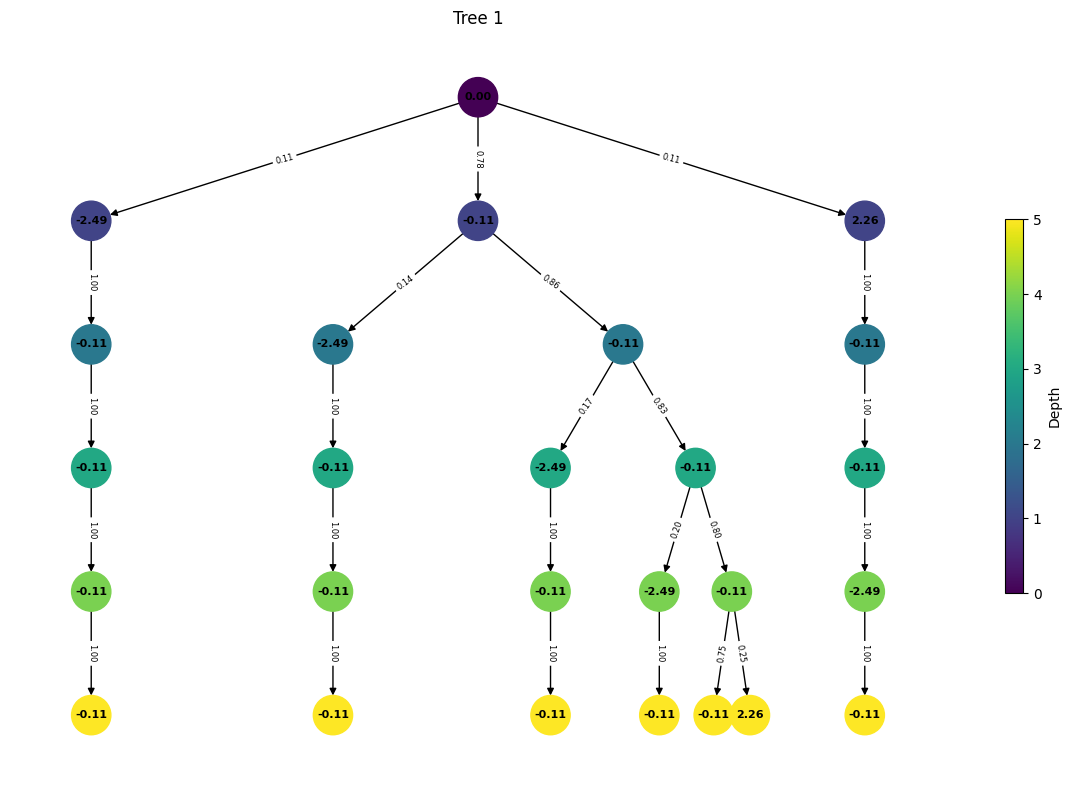

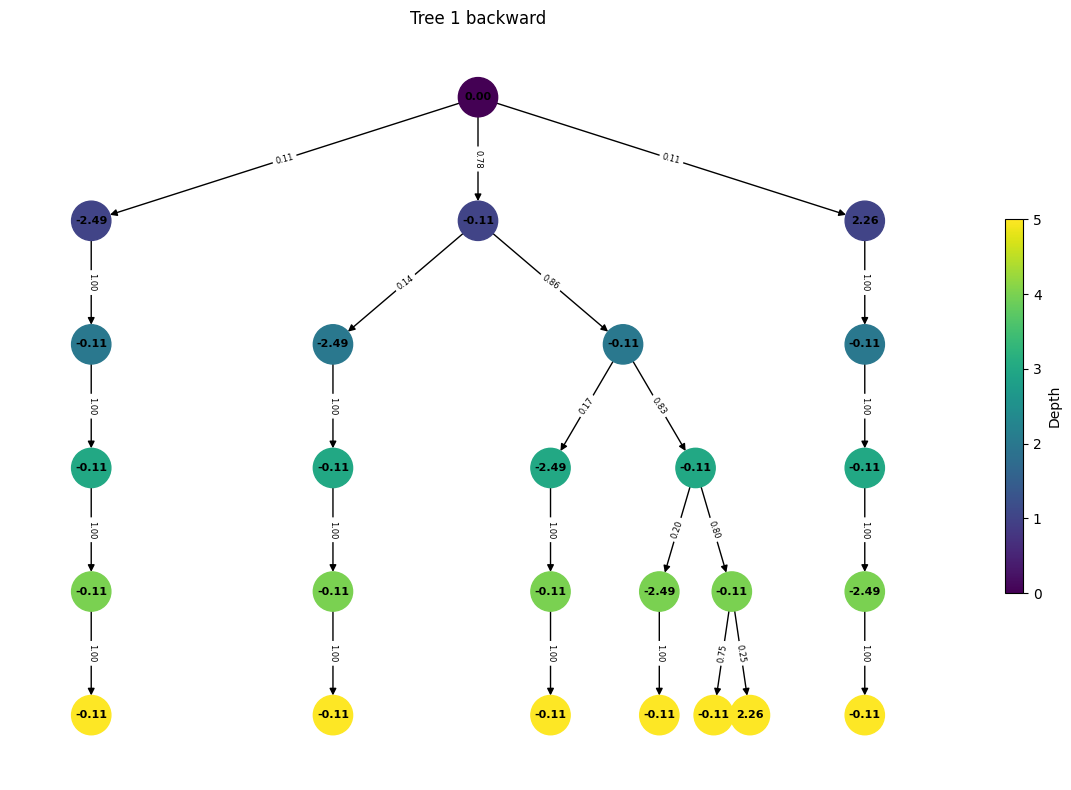

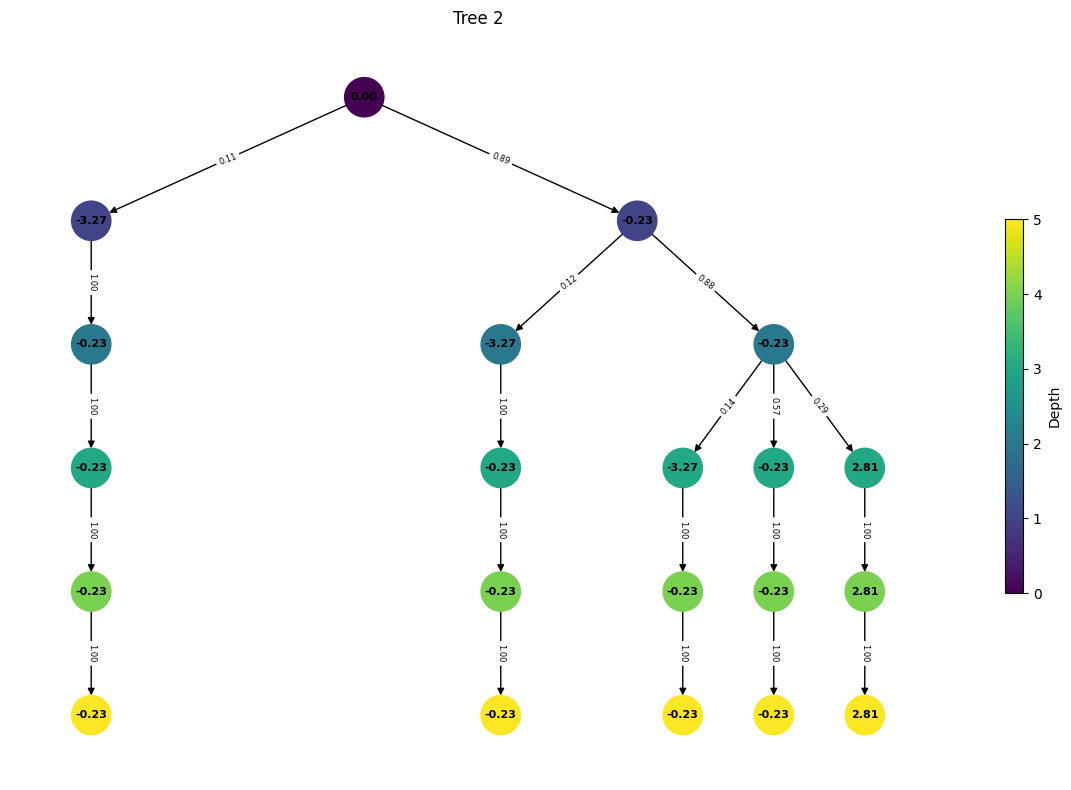

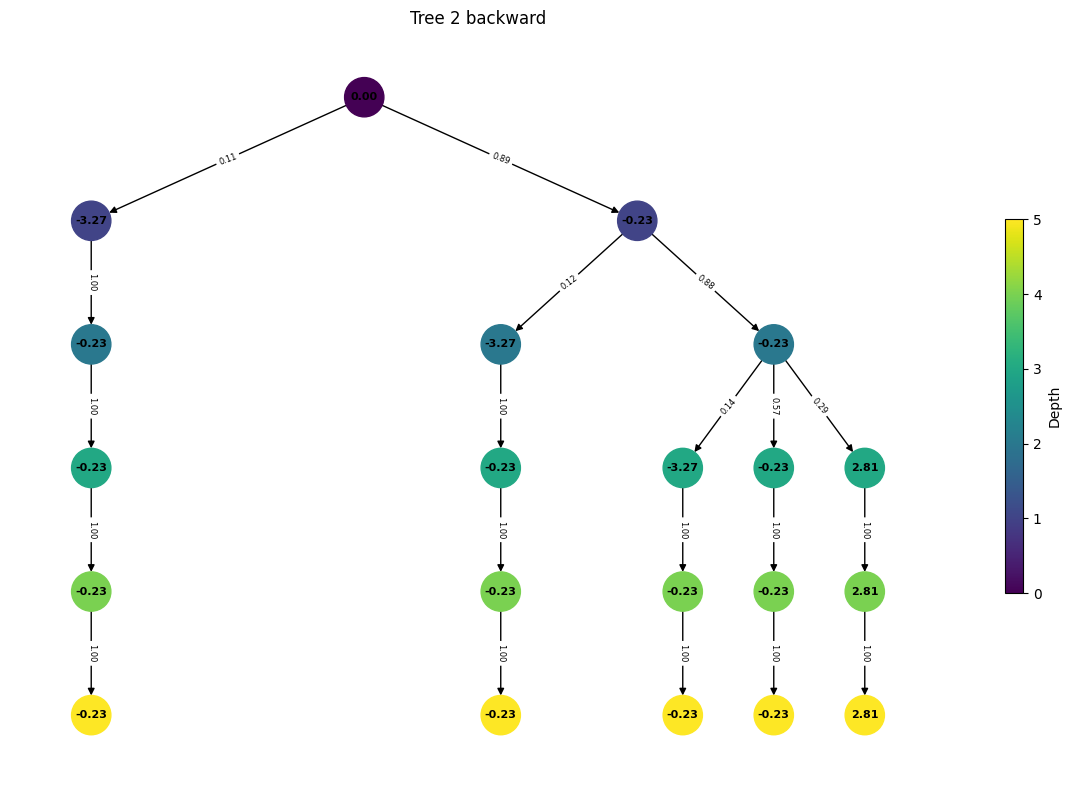

In [10]:
# Define the method and time steps to loop over
method = "grid"

# (Optional) Benchmark distance (if you had one) – here we set it to NaN since no closed form is available.
distance_benchmark = np.nan

# Noise standard deviation used in the two processes
sigma = 1.0

T = 6  # number of time steps (assumes t=0 is included)

num_paths = 9

# ---------------------------
# Generate non-Markovian sample paths:
# ---------------------------
# Process 1: Averaging Process (update uses the full past)
samplesA = np.zeros((num_paths, T))
for j in range(num_paths):
    samplesA[j, 0] = 0  # initial condition
    for t in range(1, T):
        past_mean = np.mean(samplesA[j, :t])
        samplesA[j, t] = past_mean + np.random.normal(0, sigma)

# Process 2: Weighted Noise Sum Process (each step is a weighted sum of past noise)
samplesB = np.zeros((num_paths, T))
for j in range(num_paths):
    # Generate a noise sequence for this sample path
    noise = np.random.normal(0, sigma, T)
    samplesB[j, 0] = 0  # initial condition
    for t in range(1, T):
        weighted_sum = 0
        for s in range(t):
            weight = 1 / (t - s)
            weighted_sum += weight * noise[s]
        samplesB[j, t] = weighted_sum

# (If your empirical_grid_measure function expects an extra zero column, you could add one;
# here we assume that the processes already start at zero.)
samplesA_with_zero = samplesA
samplesB_with_zero = samplesB

new_sample_pathsA, new_weightsA = empirical_grid_measure(
    samplesA_with_zero, use_weights=True
)
new_sample_pathsB, new_weightsB = empirical_grid_measure(
    samplesB_with_zero, use_weights=True
)


tree1 = build_tree_from_paths(new_sample_pathsA, new_weightsA)
tree2 = build_tree_from_paths(new_sample_pathsB, new_weightsB)

tree1_back = build_tree_from_paths_backward(new_sample_pathsA, new_weightsA)
tree2_back = build_tree_from_paths_backward(new_sample_pathsB, new_weightsB)

visualize_tree(tree1, title="Tree 1")
visualize_tree(tree1_back, title="Tree 1 backward")
visualize_tree(tree2, title="Tree 2")
visualize_tree(tree2_back, title="Tree 2 backward")

Method: grid
Time Steps: 6, Method: grid, Run 1/10 for sample size 10...
Sample Size 10, Run 1: Tree Distance = 9.6616, backward_tree Distance = 9.6616, Difference = 0.0000
Sample Size 10, Run 1: Tree Time = 0.0182s, backward_tree Time = 0.0727s, Time Diff = -0.0546s
Time Steps: 6, Method: grid, Run 2/10 for sample size 10...
Sample Size 10, Run 2: Tree Distance = 16.8163, backward_tree Distance = 16.8163, Difference = -0.0000
Sample Size 10, Run 2: Tree Time = 0.0201s, backward_tree Time = 0.0203s, Time Diff = -0.0002s
Time Steps: 6, Method: grid, Run 3/10 for sample size 10...
Sample Size 10, Run 3: Tree Distance = 12.4162, backward_tree Distance = 12.4162, Difference = -0.0000
Sample Size 10, Run 3: Tree Time = 0.0124s, backward_tree Time = 0.0125s, Time Diff = -0.0001s
Time Steps: 6, Method: grid, Run 4/10 for sample size 10...
Sample Size 10, Run 4: Tree Distance = 16.6544, backward_tree Distance = 16.6544, Difference = -0.0000
Sample Size 10, Run 4: Tree Time = 0.0151s, backward_

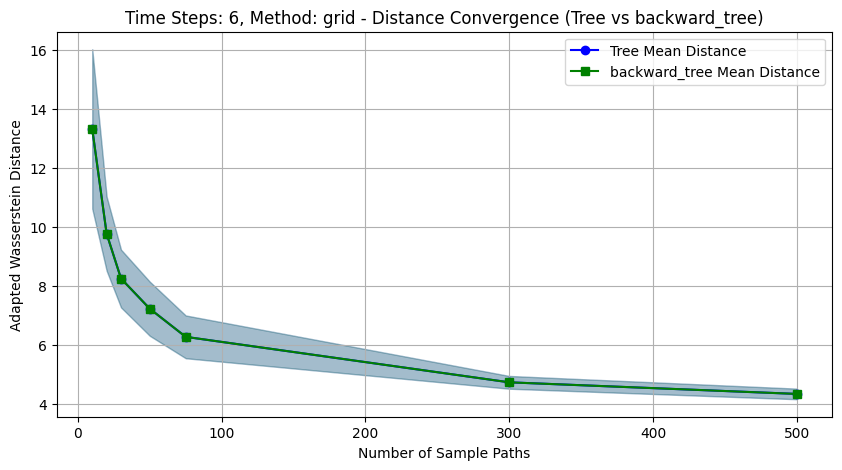

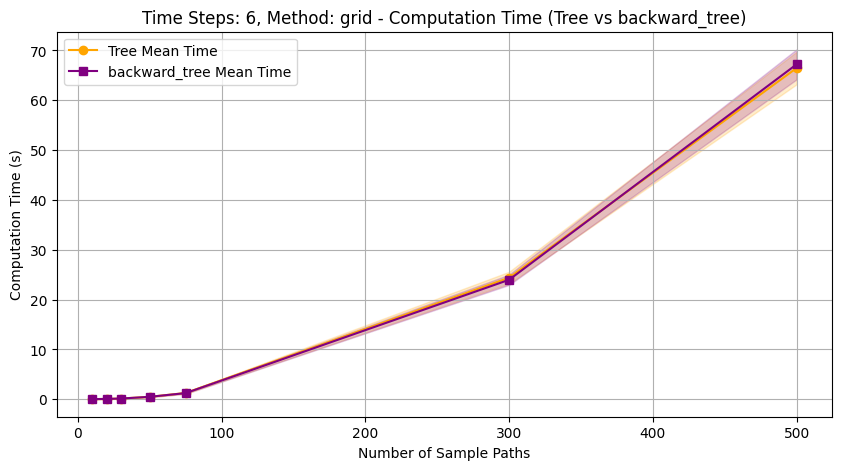

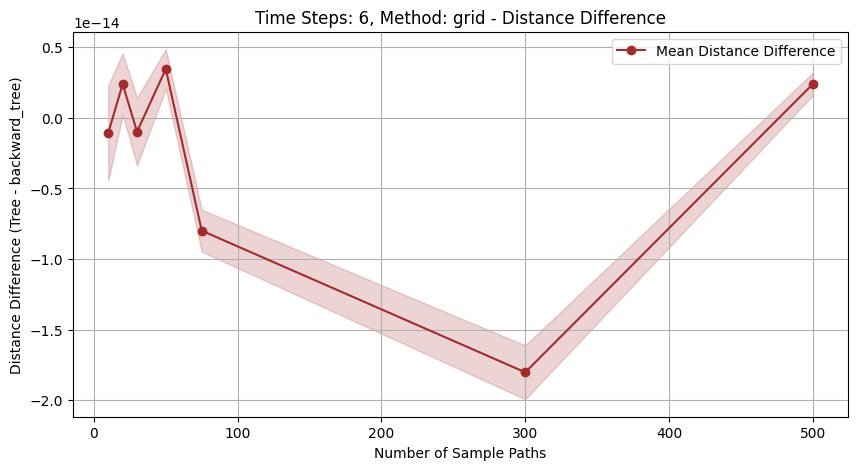

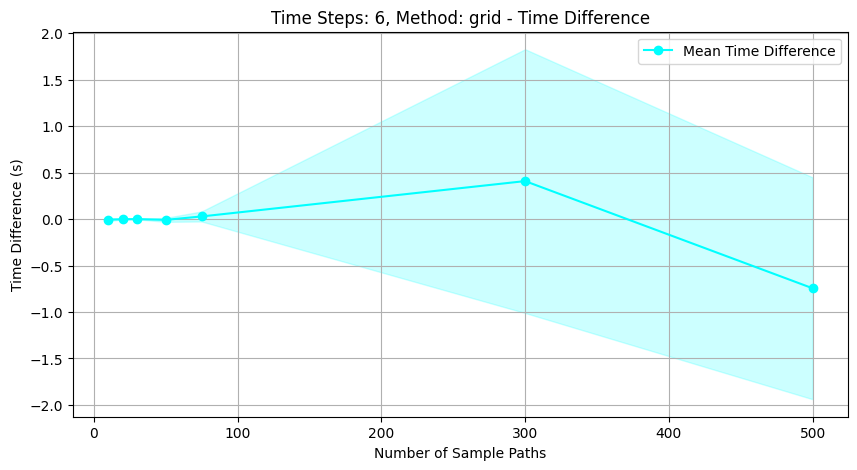

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the method and time steps to loop over
method = "grid"
time_steps_list = [6]  # total number of time steps (including t=0)
n_runs = 10

# Define sample path sizes for each time step
sample_sizes = [10, 20, 30, 50, 75, 300, 500]

# Prepare arrays for storing tree and backward_tree results
distances_all_tree = np.zeros((len(sample_sizes), n_runs))
times_all_tree = np.zeros((len(sample_sizes), n_runs))
distances_all_backward_tree = np.zeros((len(sample_sizes), n_runs))
times_all_backward_tree = np.zeros((len(sample_sizes), n_runs))
diff_distance_all = np.zeros((len(sample_sizes), n_runs))
diff_time_all = np.zeros((len(sample_sizes), n_runs))

# (Optional) Benchmark distance (if you had one) – here we set it to NaN since no closed form is available.
distance_benchmark = np.nan

# Noise standard deviation used in the two processes
sigma = 1.0

# Loop over each time step and method combination
for time_steps in time_steps_list:
    print("Method:", method)

    # Loop over each sample size and run multiple trials for statistics
    for i, num_paths in enumerate(sample_sizes):
        for run_idx in range(n_runs):
            print(
                f"Time Steps: {time_steps}, Method: {method}, Run {run_idx+1}/{n_runs} for sample size {num_paths}..."
            )

            T = time_steps  # number of time steps (assumes t=0 is included)

            # ---------------------------
            # Generate non-Markovian sample paths:
            # ---------------------------
            # Process 1: Averaging Process (update uses the full past)
            samplesA = np.zeros((num_paths, T))
            for j in range(num_paths):
                samplesA[j, 0] = 0  # initial condition
                for t in range(1, T):
                    past_mean = np.mean(samplesA[j, :t])
                    samplesA[j, t] = past_mean + np.random.normal(0, sigma)

            # Process 2: Weighted Noise Sum Process (each step is a weighted sum of past noise)
            samplesB = np.zeros((num_paths, T))
            for j in range(num_paths):
                # Generate a noise sequence for this sample path
                noise = np.random.normal(0, sigma, T)
                samplesB[j, 0] = 0  # initial condition
                for t in range(1, T):
                    weighted_sum = 0
                    for s in range(t):
                        weight = 1 / (t - s)
                        weighted_sum += weight * noise[s]
                    samplesB[j, t] = weighted_sum

            # (If your empirical_grid_measure function expects an extra zero column, you could add one;
            # here we assume that the processes already start at zero.)
            samplesA_with_zero = samplesA
            samplesB_with_zero = samplesB

            # ---------------------------
            # Compute the empirical grid measures (paths and weights)
            # ---------------------------
            new_sample_pathsA, new_weightsA = empirical_grid_measure(
                samplesA_with_zero, use_weights=True
            )
            new_sample_pathsB, new_weightsB = empirical_grid_measure(
                samplesB_with_zero, use_weights=True
            )

            # ---------------------------
            # Build tree/backward_tree representations:
            # ---------------------------
            tree1 = build_tree_from_paths(new_sample_pathsA, new_weightsA)
            tree2 = build_tree_from_paths(new_sample_pathsB, new_weightsB)

            tree1_back = build_tree_from_paths_backward(new_sample_pathsA, new_weightsA)
            tree2_back = build_tree_from_paths_backward(new_sample_pathsB, new_weightsB)

            # ---------------------------
            # Compute nested distance using the tree:
            # ---------------------------
            max_depth_tree = get_depth(tree2)
            start_time_backward_tree = time.time()
            distance_tree = compute_nested_distance(
                tree1,
                tree2,
                max_depth_tree,
                method="solver_lp_pot",
                return_matrix=False,
                lambda_reg=0,
                power=2,
            )
            elapsed_time_backward_tree = time.time() - start_time_backward_tree

            # ---------------------------
            # Compute nested distance using the backward_tree:
            # ---------------------------
            max_depth_tree = get_depth(tree1_back)
            start_time_tree = time.time()
            distance_backward_tree = compute_nested_distance(
                tree1_back,
                tree2_back,
                max_depth_tree,
                method="solver_lp_pot",
                return_matrix=False,
                lambda_reg=0,
                power=2,
            )
            elapsed_time_tree = time.time() - start_time_tree

            # (Optional) Adjust the computed distances by subtracting any constant (here, 0)
            distance_tree -= (0 - 0) ** 2
            distance_backward_tree -= (0 - 0) ** 2

            # Store the computed distances and computation times:
            distances_all_tree[i, run_idx] = distance_tree
            times_all_tree[i, run_idx] = elapsed_time_tree
            distances_all_backward_tree[i, run_idx] = distance_backward_tree
            times_all_backward_tree[i, run_idx] = elapsed_time_backward_tree

            # Also store the differences (tree - backward_tree)
            diff_distance_all[i, run_idx] = distance_tree - distance_backward_tree
            diff_time_all[i, run_idx] = elapsed_time_tree - elapsed_time_backward_tree

            print(
                f"Sample Size {num_paths}, Run {run_idx+1}: Tree Distance = {distance_tree:.4f}, backward_tree Distance = {distance_backward_tree:.4f}, Difference = {distance_tree - distance_backward_tree:.4f}"
            )
            print(
                f"Sample Size {num_paths}, Run {run_idx+1}: Tree Time = {elapsed_time_tree:.4f}s, backward_tree Time = {elapsed_time_backward_tree:.4f}s, Time Diff = {elapsed_time_tree - elapsed_time_backward_tree:.4f}s"
            )

    # ---------------------------
    # Compute statistics over runs:
    # ---------------------------
    # Tree statistics:
    distances_tree_mean = distances_all_tree.mean(axis=1)
    distances_tree_std = distances_all_tree.std(axis=1)
    times_tree_mean = times_all_tree.mean(axis=1)
    times_tree_std = times_all_tree.std(axis=1)
    # backward_tree statistics:
    distances_backward_tree_mean = distances_all_backward_tree.mean(axis=1)
    distances_backward_tree_std = distances_all_backward_tree.std(axis=1)
    times_backward_tree_mean = times_all_backward_tree.mean(axis=1)
    times_backward_tree_std = times_all_backward_tree.std(axis=1)
    # Difference statistics:
    diff_distance_mean = diff_distance_all.mean(axis=1)
    diff_distance_std = diff_distance_all.std(axis=1)
    diff_time_mean = diff_time_all.mean(axis=1)
    diff_time_std = diff_time_all.std(axis=1)

    # ---------------------------
    # PLOTTING
    # ---------------------------
    # Plot 1: Distance convergence for Tree vs. backward_tree
    plt.figure(figsize=(10, 5))
    plt.plot(
        sample_sizes,
        distances_tree_mean,
        marker="o",
        color="blue",
        label="Tree Mean Distance",
    )
    plt.plot(
        sample_sizes,
        distances_backward_tree_mean,
        marker="s",
        color="green",
        label="backward_tree Mean Distance",
    )
    plt.fill_between(
        sample_sizes,
        distances_tree_mean - distances_tree_std,
        distances_tree_mean + distances_tree_std,
        color="blue",
        alpha=0.2,
    )
    plt.fill_between(
        sample_sizes,
        distances_backward_tree_mean - distances_backward_tree_std,
        distances_backward_tree_mean + distances_backward_tree_std,
        color="green",
        alpha=0.2,
    )
    if not np.isnan(distance_benchmark):
        plt.axhline(
            y=distance_benchmark,
            color="red",
            linestyle="--",
            label="Benchmark Distance",
        )
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Adapted Wasserstein Distance")
    plt.title(
        f"Time Steps: {time_steps}, Method: {method} - Distance Convergence (Tree vs backward_tree)"
    )
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 2: Computation Time for Tree vs. backward_tree
    plt.figure(figsize=(10, 5))
    plt.plot(
        sample_sizes,
        times_tree_mean,
        marker="o",
        color="orange",
        label="Tree Mean Time",
    )
    plt.plot(
        sample_sizes,
        times_backward_tree_mean,
        marker="s",
        color="purple",
        label="backward_tree Mean Time",
    )
    plt.fill_between(
        sample_sizes,
        times_tree_mean - times_tree_std,
        times_tree_mean + times_tree_std,
        color="orange",
        alpha=0.2,
    )
    plt.fill_between(
        sample_sizes,
        times_backward_tree_mean - times_backward_tree_std,
        times_backward_tree_mean + times_backward_tree_std,
        color="purple",
        alpha=0.2,
    )
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Computation Time (s)")
    plt.title(
        f"Time Steps: {time_steps}, Method: {method} - Computation Time (Tree vs backward_tree)"
    )
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 3: Difference in Distance (Tree - backward_tree)
    plt.figure(figsize=(10, 5))
    plt.plot(
        sample_sizes,
        diff_distance_mean,
        marker="o",
        color="brown",
        label="Mean Distance Difference",
    )
    plt.fill_between(
        sample_sizes,
        diff_distance_mean - diff_distance_std,
        diff_distance_mean + diff_distance_std,
        color="brown",
        alpha=0.2,
    )
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Distance Difference (Tree - backward_tree)")
    plt.title(f"Time Steps: {time_steps}, Method: {method} - Distance Difference")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 4: Difference in Computation Time (Tree - backward_tree)
    plt.figure(figsize=(10, 5))
    plt.plot(
        sample_sizes,
        diff_time_mean,
        marker="o",
        color="cyan",
        label="Mean Time Difference",
    )
    plt.fill_between(
        sample_sizes,
        diff_time_mean - diff_time_std,
        diff_time_mean + diff_time_std,
        color="cyan",
        alpha=0.2,
    )
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Time Difference (s)")
    plt.title(f"Time Steps: {time_steps}, Method: {method} - Time Difference")
    plt.legend()
    plt.grid()
    plt.show()